## CIS 519 Group Project - Baseline CNN Architecture Implementation

### Library Imports

In [ ]:
!pip install timm

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils import data
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim 
from tqdm.notebook import tqdm
import timm
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

### Helper Functions

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [1]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [2]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

### Parameter Initialization

In [ ]:
class config_params:
    epochs = 10                              # No. of epochs for training the model
    lr = 0.001                              # Learning rate
    batch_size = 16                        # Batch Size for Dataset
    img_size = 224                          # Resize all the images to be 224 by 224   
    in_channels = 3
    num_classes = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


### Data Loading

In [ ]:
data_dir = 'dataset'
classes = os.listdir(data_dir)

In [ ]:
classes

['Hand', 'CXR', 'AbdomenCT', 'BreastMRI', 'HeadCT', 'ChestCT']

In [ ]:
train_transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [ ]:
dataset = ImageFolder(data_dir, transform= transform)
print('Size of the dataset :', len(dataset))

Size of the dataset : 58954


In [ ]:
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [ ]:
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  BreastMRI (1)


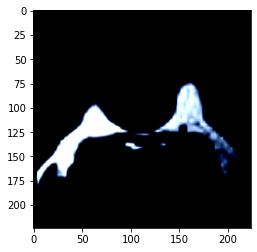

In [ ]:
show_image(*dataset[10001])

In [ ]:
# coding:utf8
import os
from PIL import Image
from torch.utils import data
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
 

Labels = {'AbdomenCT':0, 'BreastMRI':1,'CXR':2,'ChestCT':3,'Hand':4,'HeadCT':5}

class MedicalMNIST(data.Dataset):
    
 
    def __init__(self, root, transforms=None, train=True, test=False, val = False):
        """
        Main objective: to obtain the addresses of all pictures and divide the data according to training, verification and test
        """
        self.test = test
        self.val = val
        self.transforms = transforms
 
        if self.test:
            imgs = [os.path.join(root, img) for img in os.listdir(root)]
            self.imgs = imgs
        else:
            imgs_labels = [os.path.join(root, img) for img in os.listdir(root)]
            imgs = []
            for imglable in imgs_labels:
                for imgname in os.listdir(imglable):
                    imgpath = os.path.join(imglable, imgname)
                    imgs.append(imgpath)
                    
            torch.manual_seed(20)
            val_size = int(round(len(dataset) * 0.2, 0))
            test_size = int(round(len(dataset) * 0.1, 0))
            train_size = len(dataset) - val_size -test_size
            train_ds, val_ds, test_ds = random_split(imgs, [train_size, val_size, test_size])
            
            if train == True:
                self.imgs = train_ds
            elif val == True:
                self.imgs = val_ds
            else:
                self.imgs = test_ds
 
    def __getitem__(self, index):
        """
        Returns the data of one picture at a time
        """
        img_path = self.imgs[index]
        img_path=img_path.replace("\\",'/')
        if self.test:
            label = -1
        else:
            
            labelname = img_path.split('/')[-2]
            
            label = Labels[labelname]
           
        data = Image.open(img_path).convert('RGB')
        data = self.transforms(data)
        return data, label
 
    def __len__(self):
        return len(self.imgs)
    

In [ ]:
batch_size = config_params.batch_size

dataset_train = MedicalMNIST(data_dir, transforms=train_transform, train=True)
dataset_val = MedicalMNIST(data_dir, transforms=transform, train=False,val=True)
dataset_test = MedicalMNIST(data_dir,transforms=test_transform, train=False)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size= batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size= batch_size, shuffle=False)

In [ ]:
print("No. of batches in trainloader:{}".format(len(train_loader))) 
print("No. of Total examples:{}".format(len(train_loader.dataset)))

print("No. of batches in validationloader:{}".format(len(val_loader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(val_loader.dataset)))

print("No. of batches in testloader:{}".format(len(test_loader)))
print("No. of Total examples:{}".format(len(test_loader.dataset)))

No. of batches in trainloader:2580
No. of Total examples:41268
No. of batches in validationloader:737
No. of Total examples:11791
No. of batches in testloader:369
No. of Total examples:5895


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


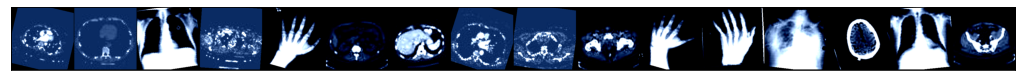

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

### Model Definition

In [ ]:
class CNN(nn.Module):
   
    def __init__(self,in_channels, num_classes=None):
        super(CNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=128 * 52 * 52, out_features=1024),
            nn.Dropout2d(p=0.3),
            nn.Linear(in_features=1024, out_features= num_classes),
            #nn.Linear(in_features=128, out_features= num_classes)
        )
    def forward(self, x):
        x = self.conv_block(x)
        bs, _, _, _ = x.shape
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Training and Testing

In [ ]:
class Trainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,train_loader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(train_loader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(outputs,labels)
            
        return train_loss / len(train_loader), train_acc / len(train_loader) 

    
    def valid_batch_loop(self,model,val_loader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(val_loader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(outputs,labels)
            
            
        return  valid_loss / len(val_loader), valid_acc / len(val_loader)
    
    def test_batch_loop(self,model,test_loader):
        y_pred = []
        y_true = []
        test_loss = 0.0
        test_acc = 0.0

        # iterate over test data
        for inputs, labels in test_loader:
                inputs = inputs.to(device) 
                labels = labels.to(device)
            
                output = model(inputs) # Feed Network
                
                loss = self.criterion(output,labels)
                
                test_loss += loss.item()
                test_acc += accuracy(output,labels)
            
                
                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction

                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth

        return y_true, y_pred, test_loss / len(test_loader), test_acc / len(test_loader)
            
        
    def fit(self,model,train_loader,valid_loader,epochs):
        train_loss, validation_loss = [], []
        train_acc, validation_acc = [], []
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,train_loader) ###
            train_loss.append(avg_train_loss)  # append the loss for this epoch
            train_acc.append(avg_train_acc)
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,valid_loader) ###
            
            validation_loss.append(avg_valid_loss)
            validation_acc.append(avg_valid_acc)
            
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))
            
        return train_loss, train_acc, validation_loss, validation_acc  

In [ ]:
in_channels = config_params.in_channels
num_classes = config_params.num_classes
lr = config_params.lr
epochs = config_params.epochs

model = CNN(in_channels,num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr)


trainer = Trainer(criterion,optimizer)

train_loss, train_acc, validation_loss, validation_acc = trainer.fit(model,train_loader,val_loader,epochs)

  0%|          | 0/2580 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 1 Train Loss : 0.696364 Train Acc : 0.728585
Epoch : 1 Valid Loss : 0.064989 Valid Acc : 0.984651


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.598037 Train Acc : 0.740334
Epoch : 2 Valid Loss : 0.031734 Valid Acc : 0.991096


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.637727 Train Acc : 0.739026
Epoch : 3 Valid Loss : 0.053948 Valid Acc : 0.993046


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.617537 Train Acc : 0.742708
Epoch : 4 Valid Loss : 0.053872 Valid Acc : 0.992622


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.581458 Train Acc : 0.748232
Epoch : 5 Valid Loss : 0.037026 Valid Acc : 0.993216


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.577626 Train Acc : 0.742951
Epoch : 6 Valid Loss : 0.053059 Valid Acc : 0.993894


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.606422 Train Acc : 0.742418
Epoch : 7 Valid Loss : 0.042950 Valid Acc : 0.993894


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.562336 Train Acc : 0.748716
Epoch : 8 Valid Loss : 0.041963 Valid Acc : 0.989654


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.603885 Train Acc : 0.748353
Epoch : 9 Valid Loss : 0.076885 Valid Acc : 0.991684


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.584710 Train Acc : 0.744138
Epoch : 10 Valid Loss : 0.046369 Valid Acc : 0.991520


In [ ]:
model.eval()
true, pred, avg_test_loss, avg_test_acc= trainer.test_batch_loop(model,test_loader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test Loss : 0.05535767285925275
Test Acc : 0.9901761412620544


### Result Visualization

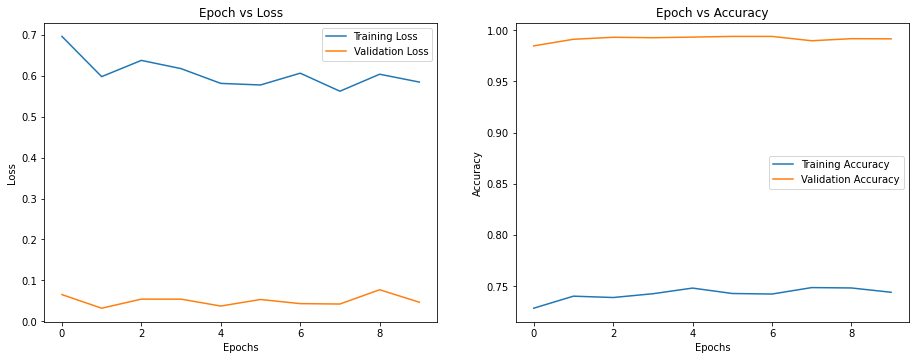

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

Confusion Matrix for CNN


[[ 983    0    0    0    0    0]
 [   0  915    0    0    2    2]
 [   0    1  972    0   14    2]
 [   0    0    0  955    0    0]
 [   0    4    3    3  984   23]
 [   0    1    0    0    3 1028]]


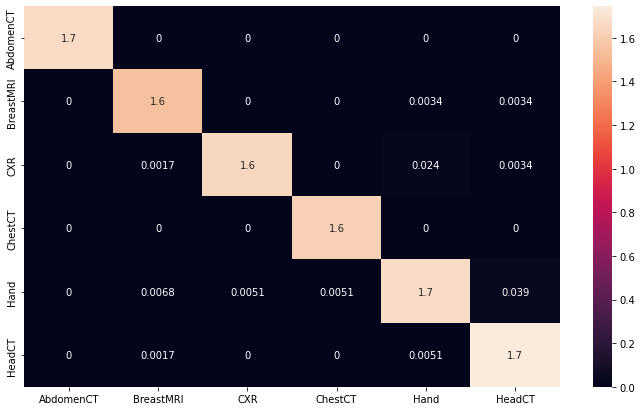

In [ ]:
# constant for classes
classes = ['AbdomenCT', 'BreastMRI','CXR','ChestCT','Hand','HeadCT']

# Build confusion matrix
cf_matrix = confusion_matrix(true, pred)
print("Confusion Matrix for CNN")
print("\n")
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)